In [2]:
#module import#
from urllib.request import urlopen
from urllib.error import HTTPError
from urllib.error import URLError
from bs4 import BeautifulSoup
from pandas import DataFrame
import re
import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Crawl Data

In [61]:
#code partially from: https://github.com/Jhruzik/ImmobilienScout24.de-Crawler
#get current date#
current_datetime_master = datetime.datetime.now()
current_datetime = current_datetime_master.strftime("%Y%m%d_%H%M%S")

#define sub-sites# 
#Info for immoscout:
domain = "https://www.immobilienscout24.de"
city = "Osnabrueck"
state = "Niedersachsen"
renttype = "/Wohnung-Miete"
#info for wg-gesucht:
domain2 = "https://www.wg-gesucht.de/"#wohnungen-in-
renttype2 = "wohnungen"
immoscout_data = DataFrame()

def get_max(url):
    try:
        url = urlopen(url)
    except:
        print("Fehler beim Oeffnen der Website")
    try:
        site_extract = BeautifulSoup(url.read(), "lxml")
    except:
        print("Fehler beim Einlesen in BeautifulSoup")
    try:
        max_link = max([int(n["value"]) for n in site_extract.find_all("option")])#get the maximum value for links in a specific sub-site
    except:
        print("Fehler beim Loop")
    else:
        return max_link

def get_data(url,website):
    try:
        url_raw = url#save url as string for real estate type
        url = urlopen(url)
    except HTTPError as e:
        return None
    except URLError as e:
        return None
    try:
        site_extract = BeautifulSoup(url.read(), "lxml")
        if website=='immoscout':
            rawdata_extract = site_extract.find_all("div", {"class":"result-list-entry__data"})#extract every result box
        if website == 'wggesucht':
            rawdata_extract = site_extract.find_all("div", {"class":"detail-size-price-wrapper"})
    except AttributeError as e:
        return None
    global immoscout_data#use global dataframe
    price = []
    size = []
    location = []
    ownership = []
    immo_type = []
    links = []
    for i in range(0,len(rawdata_extract)):
        if website=='immoscout':
            try:
                price.append(rawdata_extract[i].find_all("dd")[0].get_text().strip())#extract price
            except:
                price.append("?")
            try:
                size.append(rawdata_extract[i].find_all("dd")[1].get_text().strip())#extract size
            except:
                size.append("?")
            try:
                location.append(rawdata_extract[i].find_all("div", {"class":"result-list-entry__address"})[0].get_text().strip())#extract location
            except:
                location.append("?")
            try:
                hrefs = []
                for a in rawdata_extract[i].find_all('a', href=True):
                    hrefs.append(a['href'])

                links.append(domain+hrefs[0])
            except:
                links.append("?")
        if (website=='wggesucht' and i>1):#skip first two entries in wggesucht (advertisement):
            text = rawdata_extract[i].get_text().replace(" ", "").strip()
            metersplit = text.split('m')
            pricesplit = metersplit[1].split('|')[1].split('€')[0]
            price.append(pricesplit)
            size.append(metersplit[0])
            hrefs = []
            for a in rawdata_extract[i].find_all('a', href=True):
                hrefs.append(a['href'])
            loc = hrefs[0].split('-')
            links.append(domain2+hrefs[0])
            location.append(loc[-1].split('.')[0])
    immoscout_data = immoscout_data.append(DataFrame({"price":price, 
                                                  "size":size,
                                                  "location":location,
                                                      "link":links}), 
    ignore_index=True)

def immo_crawl(site,website):
    max_dict = {}#initialize dictionary for maximum values of links
    link_list_full = []#initialize list for full links to crawl#
    if website =="immoscout":
        maxcrawl = get_max(domain+"/Suche/S-T"+site+"/"+state+"/"+city)#associate maximal link value with specific sub-site
        for i in range(1,maxcrawl):
            link_list_full.append(domain+"/Suche/S-T/P-"+str(i)+site+"/"+state+"/"+city)#populate link_list_full
    if website =="wggesucht":
        #maxcrawl = get_max(domain2+site+"-in-"+city+".102.2.1.0.html")
        for i in range(1,3):
            link_list_full.append(domain2+site+"-in-"+city+".102.2.1."+str(i)+".html")
    link_count = 1#start for progress indicator
    len_link_list_full = len(link_list_full)#end for progress indicator
    for link in link_list_full:
        print("Crawling: "+link+" (link #"+str(link_count)+" of "+str(len_link_list_full)+")")#print progress
        link_count += 1#add to progress indicator
        get_data(link,website)
    
    
#Start crawler! Which websites do you want to analyze?--------------------------------------------------------        
immo_crawl(renttype,"immoscout")#start crawler
#immo_crawl(renttype2,"wggesucht")

#save tabel as csv
#immoscout_data.to_csv("immoscoutOS_data_raw_"+current_datetime+".csv", sep=";", index=False)#export unprocessed data

#clean data#
def clean_pricesize(data):
    data = data.replace("€", "")
    data = data.replace(".", "")
    data = data.replace("m²", "")
    data = re.sub(re.compile(" \D.*"), "", data)
    data = data.strip()
    data = data.split(',')[0]
    return float(data)


def get_firstlayer(data):
    fist_layer = data.split(",")[0]
    return fist_layer.strip()

def get_secondlayer(data):
    try:
        first_layer = data.split(",")[-2]
    except:
        first_layer = data
    return first_layer.strip()

def get_lastlayer(data):
    last_layer = data.split(",")[-1]
    return last_layer.strip()
    
immoscout_data_clean = immoscout_data.dropna(axis=0)
immoscout_data_clean["price"] = immoscout_data_clean["price"].apply(clean_pricesize)
immoscout_data_clean["size"] = immoscout_data_clean["size"].apply(clean_pricesize)
immoscout_data_clean["adress"] = immoscout_data_clean["location"].apply(get_firstlayer)

immoscout_data_clean["area"] = immoscout_data_clean["location"].apply(get_secondlayer)
immoscout_data_clean["city"] = city#immoscout_data_clean["location"].apply(get_lastlayer)

immoscout_data_clean["crawled"] = current_datetime_master.strftime("%Y-%m-%d %H:%M:%S")
immoscout_data_clean['pricesize'] = immoscout_data_clean['price'] / immoscout_data_clean['size']
#immoscout_data_clean.to_csv("immoscoutOS_data_clean_"+current_datetime+".csv", sep=";", index=False)


Crawling: https://www.immobilienscout24.de/Suche/S-T/P-1/Wohnung-Miete/Niedersachsen/Osnabrueck (link #1 of 8)
Crawling: https://www.immobilienscout24.de/Suche/S-T/P-2/Wohnung-Miete/Niedersachsen/Osnabrueck (link #2 of 8)
Crawling: https://www.immobilienscout24.de/Suche/S-T/P-3/Wohnung-Miete/Niedersachsen/Osnabrueck (link #3 of 8)
Crawling: https://www.immobilienscout24.de/Suche/S-T/P-4/Wohnung-Miete/Niedersachsen/Osnabrueck (link #4 of 8)
Crawling: https://www.immobilienscout24.de/Suche/S-T/P-5/Wohnung-Miete/Niedersachsen/Osnabrueck (link #5 of 8)
Crawling: https://www.immobilienscout24.de/Suche/S-T/P-6/Wohnung-Miete/Niedersachsen/Osnabrueck (link #6 of 8)
Crawling: https://www.immobilienscout24.de/Suche/S-T/P-7/Wohnung-Miete/Niedersachsen/Osnabrueck (link #7 of 8)
Crawling: https://www.immobilienscout24.de/Suche/S-T/P-8/Wohnung-Miete/Niedersachsen/Osnabrueck (link #8 of 8)


In [52]:
immoscout_data_clean

,link,location,price,size,adress,area,city,crawled,pricesize
0,https://www.immobilienscout24.de/expose/105215722,"Adolfstraße x, Weststadt, Osnabrück",1690.0,169.0,Adolfstraße x,Weststadt,Osnabrueck,2018-06-10 13:37:13,10.000000
1,https://www.immobilienscout24.de/expose/104577740,"Paul-Oeser-Str. 4, Innenstadt, Osnabrück",1010.0,94.0,Paul-Oeser-Str. 4,Innenstadt,Osnabrueck,2018-06-10 13:37:13,10.744681
2,https://www.immobilienscout24.de/expose/104576624,"Paul-Oeser-Straße 4, Innenstadt, Osnabrück",1920.0,186.0,Paul-Oeser-Straße 4,Innenstadt,Osnabrueck,2018-06-10 13:37:13,10.322581
3,https://www.immobilienscout24.de/expose/103852417,"Ernst-Sievers-Str. 180, Whg-Nr. 2, Weststadt, ...",1050.0,80.0,Ernst-Sievers-Str. 180,Weststadt,Osnabrueck,2018-06-10 13:37:13,13.125000
4,https://www.immobilienscout24.de/expose/105343003,"Hafen, Osnabrück",405.0,63.0,Hafen,Hafen,Osnabrueck,2018-06-10 13:37:13,6.428571
5,https://www.immobilienscout24.de/expose/105212758,"Wersener Str. 40, Whg-Nr. 7, Eversburg, Osnabrück",350.0,51.0,Wersener Str. 40,Eversburg,Osnabrueck,2018-06-10 13:37:13,6.862745
6,https://www.immobilienscout24.de/expose/103852903,"Ernst-Sievers-Str. 108, Whg-Nr. 4, Weststadt, ...",1900.0,141.0,Ernst-Sievers-Str. 108,Weststadt,Osnabrueck,2018-06-10 13:37:13,13.475177
7,https://www.immobilienscout24.de/expose/47163501,"Töpferhof 16, Hellern, Osnabrück",580.0,94.0,Töpferhof 16,Hellern,Osnabrueck,2018-06-10 13:37:13,6.170213
8,https://www.immobilienscout24.de/expose/105100466,"Lange Str. 13, Westerberg, Osnabrück",320.0,30.0,Lange Str. 13,Westerberg,Osnabrueck,2018-06-10 13:37:13,10.666667
9,https://www.immobilienscout24.de/expose/98708559,"Mozartstraße 2, Weststadt, Osnabrück",650.0,80.0,Mozartstraße 2,Weststadt,Osnabrueck,2018-06-10 13:37:13,8.125000


# Some Visualizations of Overall Statistics

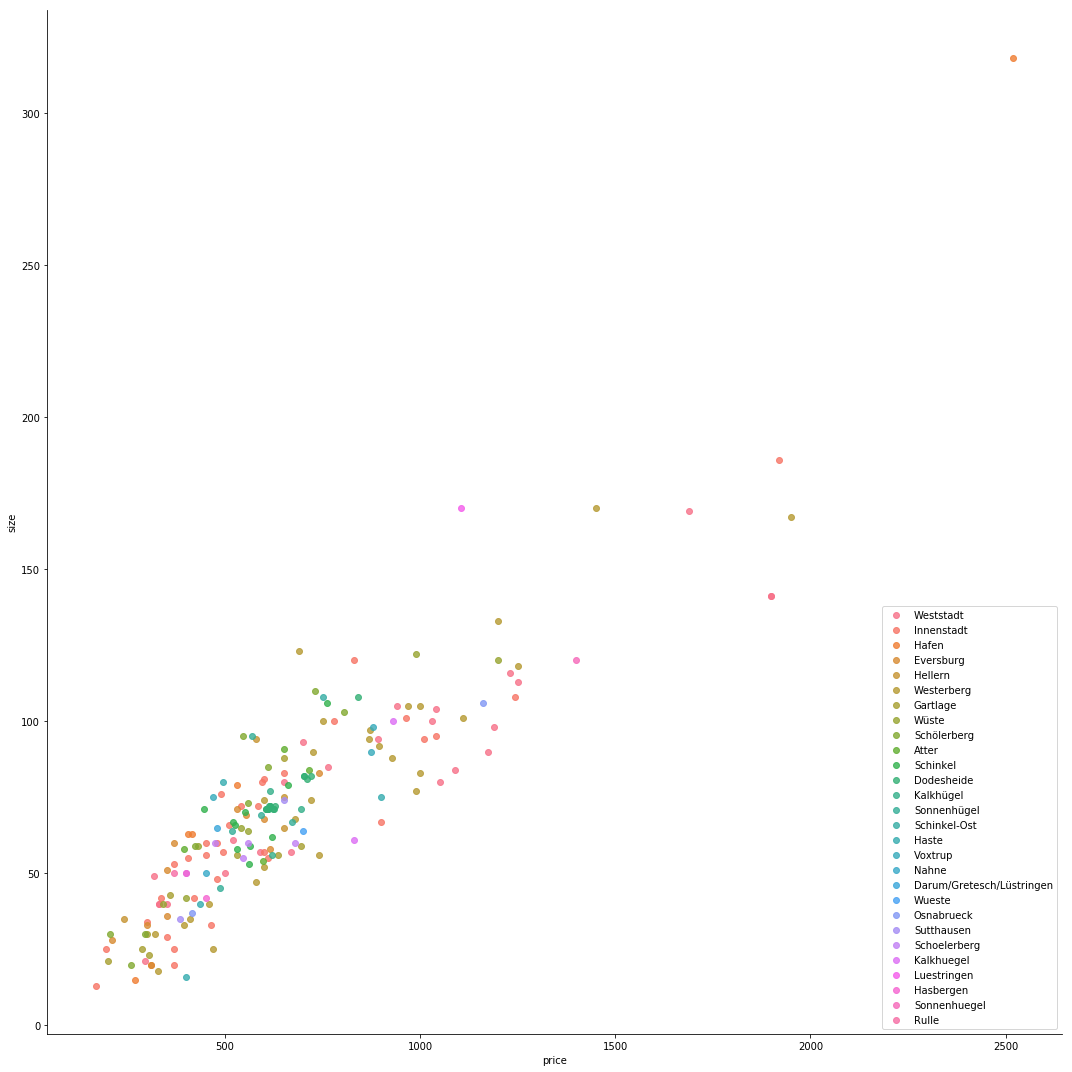

In [53]:
sns.lmplot( x="price", y="size", data=immoscout_data_clean, fit_reg=False, hue='area', legend=False,size=15)
plt.legend(loc='lower right')
plt.show()

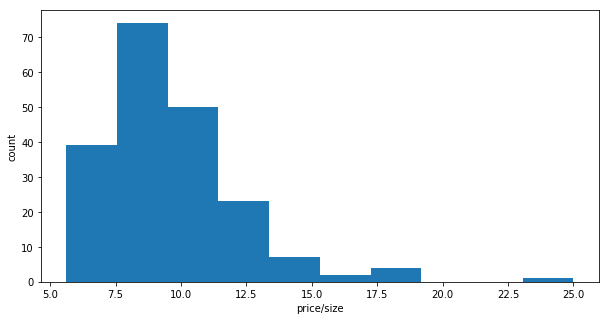

In [55]:
fig = plt.figure(figsize=(10,5))
plt.hist(immoscout_data_clean['pricesize'])
plt.xlabel('price/size')
plt.ylabel('count')
plt.show()

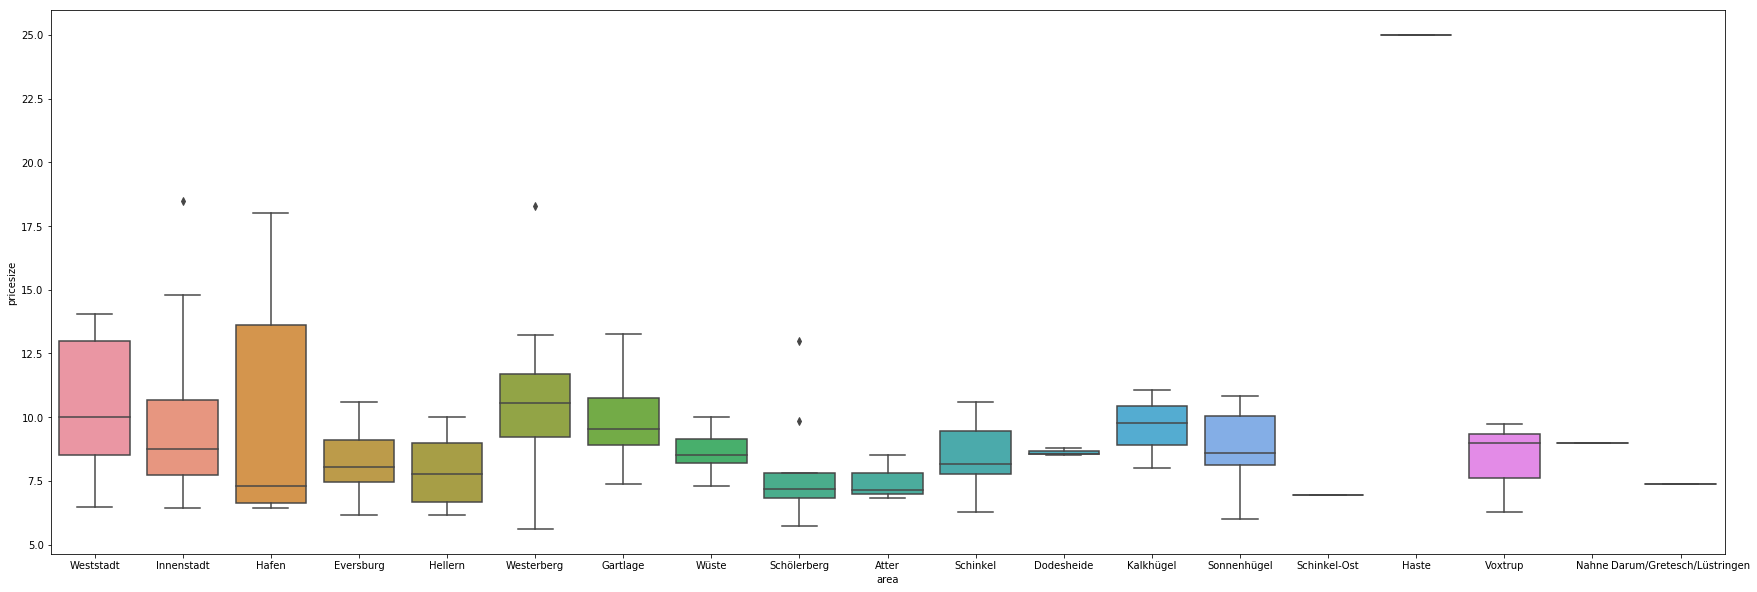

In [65]:
plt.figure(figsize=(30,10))
sns.boxplot( x="area", y="pricesize", data=immoscout_data_clean)
plt.show()

# Draw map
Size of circles = Size of appartement

Color of circles = Price-Size relationship (green: good, red: bad)

In [58]:
#Import folium and geocoders for map visualization
import folium
from folium import plugins
from geopy.geocoders import Nominatim
geolocator = Nominatim()

In [59]:
#get coordinates of appartements (don't run too often, at some point the crawler gets blocked)
long = []
lat = []
for i,row in immoscout_data_clean.iterrows():
    try:
        loc = geolocator.geocode(row.location)
        long.append(loc.longitude)
        lat.append(loc.latitude)
    except:
        try:
            loc = geolocator.geocode(row.adress+','+row.city)
            long.append(loc.longitude)
            lat.append(loc.latitude)
        except:
            print(row.location)
            loc = geolocator.geocode(city)
            long.append(loc.longitude)
            lat.append(loc.latitude)

Wersener Str. 40, Whg-Nr. 7, Eversburg, Osnabrück


In [60]:
#display interactable map
#code partially from https://github.com/rafaelpierre/going-dutch/
m = folium.Map([52.2799,8.0472], zoom_start=12, tiles='Stamen Toner')
for i,row in immoscout_data_clean.iterrows():
    
    #red = int((row.pricesize / immoscout_data_clean.pricesize.max()) * 255)
    red = int(row.pricesize * 15)
    green = 255 - red
    
    colorhtml = '#%02x%02x%02x' % (red, green, 0) #convert rgb to html
    size=row.price/row.pricesize
    if row.price<700:
        house_string = '{}€ - {}m2'.format(row.price,size)
        html = '<p>{}</p><a href="{}"target="_blank"> "Go There!" </a>'.format(house_string,row.link)
        iframe = folium.IFrame(html, width=150, height=80)
        popup = folium.Popup(iframe, max_width=2650)

        marker = folium.CircleMarker(location=[float(lat[i]),float(long[i])], radius=(size/10), color=colorhtml, fill=colorhtml, fill_opacity='0.3', popup=popup)
        m.add_child(marker)
m